# Simulated Strychnine Example: SI Figure 8

In this example, CUPID is used to process a simulated 2DJ dataset derived using the chemical shifts and scalar couplings of strychnine ([_200 and more NMR experiments: a practical course_](https://www.wiley.com/en-us/200+and+More+NMR+Experiments%3A+A+Practical+Course-p-9783527310678)).

The data was generated using Spinach. See `make_data.m` for the script used for the simulation, and `jres_seq.m` for the pulse sequence.

## Configure Experiment Info

N.B. generally this configuration is not necessary, as the experiment details are read from acquisition files (i.e. `acqus` and `acqu2s`).

The same parameters defined here are used in `make_data.mat`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import nmrespy as ne
import numpy as np

field = 11.74  # B0 (Tesla)
gamma = 2.6752218744e8  # γH (s⁻¹ T⁻¹)
offset = 2500.0  # Hz
sw1 = 50.0  # Hz
sw2 = 5000.0  # Hz
pts1 = 128
pts2 = 8192
sfo = ((gamma * field / (2 * np.pi)) + offset) * 1e-6  # MHz

expinfo = ne.ExpInfo(
    dim=2,
    sw=(sw1, sw2),
    offset=(0., 2500.),
    pts=(pts1, pts2),
    sfo=(None, sfo),
    nuclei=(None, "1H"),
)

find_spec("matlab"): None


## Load and Preprocess the Data

In [3]:
from pathlib import Path

from scipy.io import loadmat
import numpy as np

# Set numpy random seed to ensure reproducibility (i.e. same noise is generated)
np.random.seed(0)

output_dir = Path("output")
if not output_dir.is_dir():
    output_dir.mkdir()



estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    fid_2dj = loadmat("matlab_sim/fid_2dj.mat")["fid_2dj"]
    # Transpose the FID.
    fid_2dj = fid_2dj.T
    # Add AWGN to with target SNR of 20dB.
    fid_2dj = ne.sig.add_noise(fid_2dj, 20.0)
    # Create NMR-EsPy 2DJ estimatior object containing the FID and the experiment info.
    estimator = ne.Estimator2DJ(fid_2dj, expinfo)
    # Add some exponential apodization
    estimator._data = ne.sig.exp_apodisation(estimator._data, k=3., axes=[0])
    estimator._data = ne.sig.exp_apodisation(estimator._data, k=7., axes=[1])
    # Spianch output is 90° phase shifted in the direct dimension. This needs to be corrected.
    estimator.phase_data(p0=0.5 * np.pi, p1=0.)
    estimator.to_pickle(estimator_path)

## Visualising the Spectrum

### Direct dimension (1D)

In [4]:
import matplotlib.pyplot as plt
import copy

def plot_1d(fids):
    fig, ax = plt.subplots(
        gridspec_kw=dict(
            left=0.01,
            right=0.99,
            bottom=0.15,
        ),
        figsize=(10., 3)
    )

    xleft, xright = float("-inf"), float("inf")
    for fid in fids:
        # Zero-fill: automatically fills to next power of 2
        fid = ne.sig.zf(fid)
        # Halve initial point for FT
        fid[0] *= 0.5
        # This function does both the requisite FFT shift and FFT
        spectrum = ne.sig.ft(fid)
        # Chemical shifts is direct dimension, with the same number of points as the FID
        shifts = estimator.get_shifts(unit="ppm", meshgrid=False, pts=(1, fid.size))[1]
        xleft = max(xleft, shifts[0])
        xright = min(xright, shifts[-1])
        ax.plot(shifts, spectrum.real, lw=0.8)
        
    ax.set_xlim(xleft, xright)
    ax.set_xlabel("$^{1}$H (ppm)")
    ax.set_yticks([])

    return fig, ax

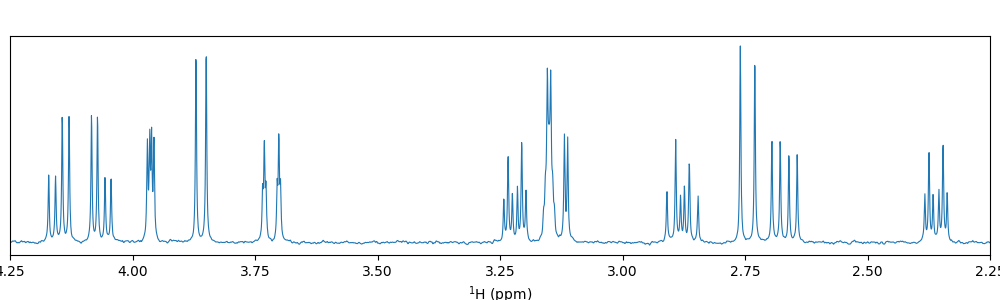

In [5]:
# First direct-dimension FID
direct_fid = copy.deepcopy(estimator._data[0])
fig, ax = plot_1d([direct_fid])
ax.set_xlim(4.25, 2.25);

### 2DJ

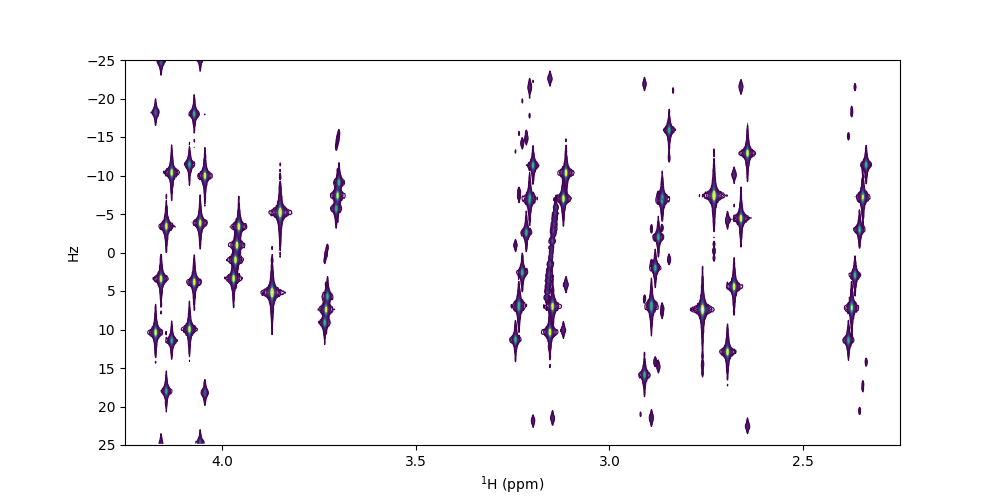

In [6]:
fid = copy.deepcopy(estimator._data)
fid = ne.sig.sinebell_apodisation(fid)
fid = ne.sig.zf(fid)
fid[0, 0] *= 0.5
spectrum = np.abs(ne.sig.ft(fid)).real
f1_shifts, f2_shifts = estimator.get_shifts(unit="ppm", pts=spectrum.shape)
fig, ax = plt.subplots(figsize=(10., 5.))
nlevels = 12
factor =1.52
base = 3.0
xx, yy = np.meshgrid(*[np.arange(n) for n in spectrum.shape], indexing="ij")
levels = [base * factor ** n for n in range(nlevels)]
ax.contour(f2_shifts, f1_shifts, spectrum, levels=levels, linewidths=0.8, cmap="viridis")
ax.set_xlim(f2_shifts[0][0], f2_shifts[0][-1])
ax.set_ylim(f1_shifts[0][0], f1_shifts[-1][0])
ax.set_xlabel("$^{1}$H (ppm)")
ax.set_ylabel("Hz")
ax.set_xticks([0.5 * i for i in range(22)])
ax.set_yticks([5.0 * i for i in range(-5, 6)])
ax.set_xlim(4.25, 2.25)
plt.show()

## Performing the Estimation

In [7]:
# Define regions to estimate (ppm)
regions = [
    (8.14, 8.05), (7.30, 7.05), (5.96, 5.87), (4.35, 4.00),
    (4.00, 3.64), (3.30, 3.05), (3.00, 2.56), (2.45, 2.25),
    (2.00, 1.74), (1.55, 1.35), (1.35, 1.20),
]
noise_region = (9.5, 9.3)

# Checking whether estimation has already been carried out
# `get_results()` raises an error if `estimate()` is yet to be called.
try:
    estimator.get_results()
except ValueError:
    # Estimate each region
    for region in regions:
        estimator.estimate(
            region=region,
            noise_region=noise_region,
            region_unit="ppm",
        )
        # Save updated estimator to disc after each region is estimated.
        # `force_overwrite=True` ensures that the user is not prompted to
        # overwrite the preexisting file.
        estimator.to_pickle(estimator_path, force_overwrite=True)

┌───────────────────────────────────────┐
│ESTIMATING REGION: 8.14 - 8.05 ppm (F2)│
└───────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 6
--> Pencil parameters: 64, 41
--> Enhanced Block Hankel matrix constructed:
	Size: 2624 x 2665
	Memory: 0.1042GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 2 secs, 556 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.75741      │ 5.76805      │ 1    

## Plotting the Estimation Result

A plot of the result can no be produced using the `plot_result()` method. 

In [8]:
import matplotlib.pyplot as plt

def plot_result(estimator):
    fig, axs = estimator.plot_result(
        region_unit="ppm",
        xaxis_ticks=[(0, [8.1]), (2, [5.9])],
        marker_size=10.0,
        multiplet_lw=0.8,
        contour_color="#404040",
        contour_base=1.5,
        contour_nlevels=12,
        contour_factor=3.0,
        contour_lw=0.4,
        axes_bottom=0.1,
        axes_left=0.11,
        figsize=(24.0, 6.0)
    )
    return fig, axs

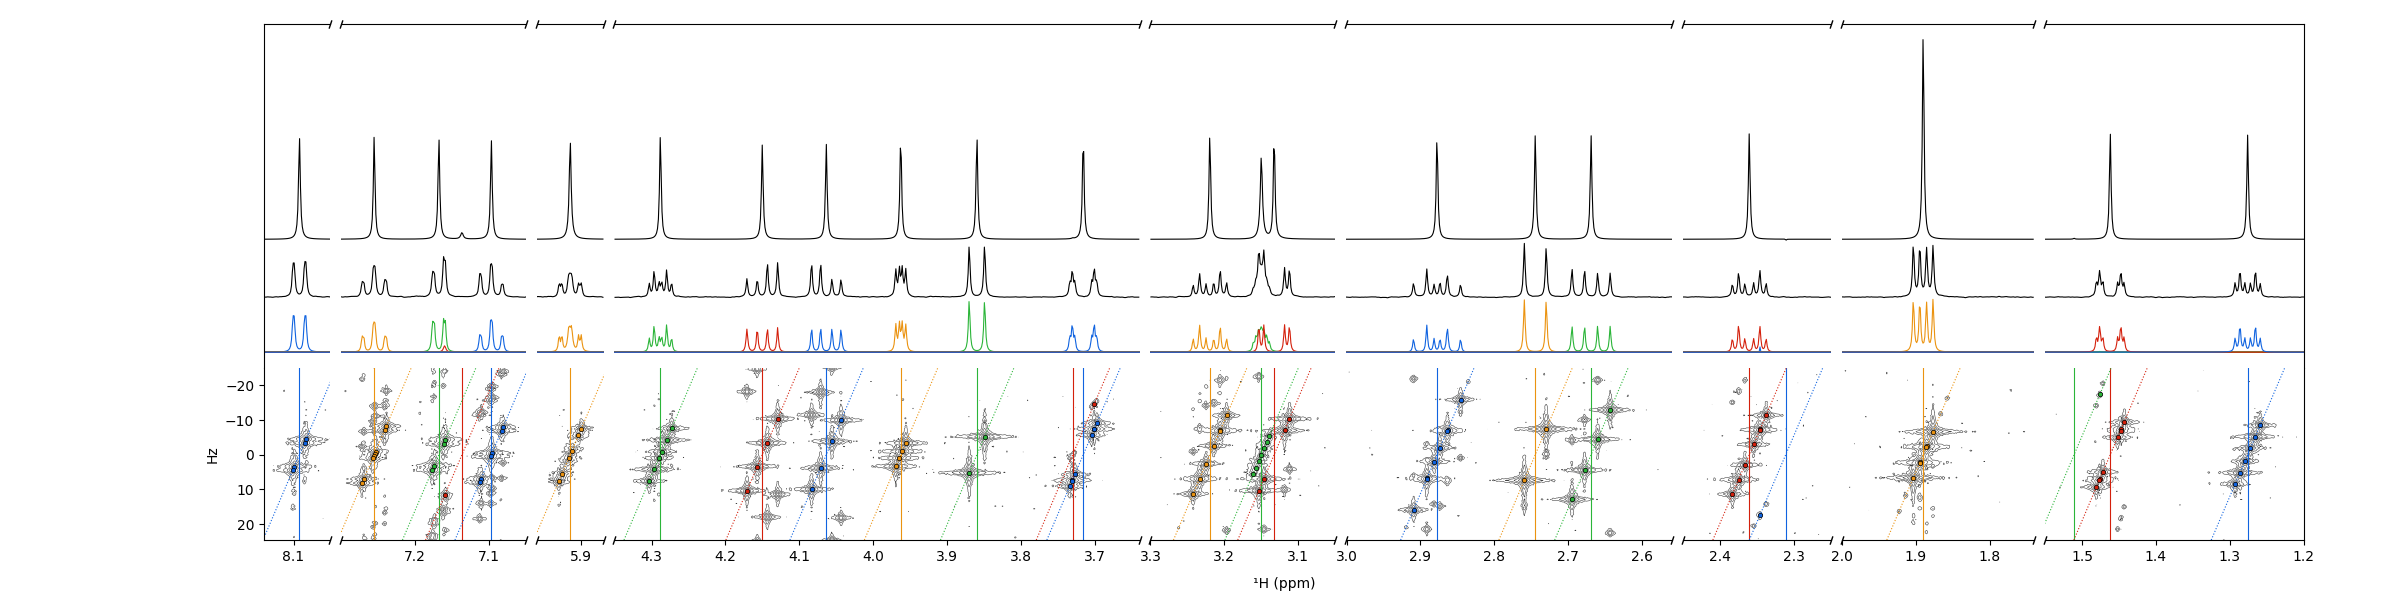

In [9]:
fig, _ = plot_result(estimator)

## Inspecting and Removing Spurious Signals
Some the signals arising from strong coupling artifacts have been fit. Most haven't, since basing the initial model selection on the direct-dimension FID should make the strong coupling artifacts undetectable. Many of these can be noticed if we call the `predict_multiplets` method: 

In [10]:
multiplets = estimator.predict_multiplets()
for cfreq, indices in multiplets.items():
    print("{:.3f} ppm : {}".format(cfreq / estimator.sfo[1], indices))

1.276 ppm : [0, 1, 2, 3, 4, 5]
1.462 ppm : [6, 7, 8, 9, 10, 11, 13, 14]
1.511 ppm : [12]
1.890 ppm : [15, 16, 17, 18, 19, 20]
2.311 ppm : [23]
2.360 ppm : [21, 22, 24, 25, 26, 27, 28]
2.669 ppm : [29, 30, 31, 32]
2.745 ppm : [33, 34]
2.878 ppm : [35, 36, 37, 38, 39, 40, 41, 42]
3.133 ppm : [43, 44, 48, 50]
3.150 ppm : [45, 46, 47, 49, 51, 52, 53]
3.220 ppm : [54, 55, 56, 57, 58, 59, 60]
3.716 ppm : [61, 62, 64, 65, 66, 67, 68, 69]
3.731 ppm : [63]
3.860 ppm : [70, 71]
3.963 ppm : [72, 73, 74, 75]
4.064 ppm : [76, 77, 78, 79]
4.150 ppm : [80, 81, 82, 83]
4.288 ppm : [84, 85, 86, 87, 88, 89]
5.915 ppm : [90, 91, 92, 93, 94, 95]
7.097 ppm : [96, 97, 98, 99, 100, 101]
7.137 ppm : [103]
7.168 ppm : [102, 104, 105, 106]
7.255 ppm : [107, 108, 109, 110, 111, 112, 113, 114]
8.092 ppm : [115, 116, 117, 118]


Lines which have a single index (1.511 ppm, 2.309 ppm, etc.) are candidates for automatic removal as they may violate the first-order signal criteria (i.e. there is either more than one signal in a multiplet, or if there is a single signal, it has an indirect freqeuncy which is sifficiently close to 0 Hz).

In [11]:
params = estimator.get_params(funit="ppm")
print("Groups with a single signal (f1, f2):")
for indices in multiplets.values():
    if len(indices) > 1:
        continue
    index = indices[0]
    signal_params = params[index]
    f1, f2 = signal_params[2:4]
    print("{}: ({:.2f} Hz, {:.2f} ppm)".format(index, f1, f2))

Groups with a single signal (f1, f2):
12: (-17.37 Hz, 1.48 ppm)
23: (17.36 Hz, 2.35 ppm)
63: (-14.62 Hz, 3.70 ppm)
103: (11.72 Hz, 7.16 ppm)


All of the above have indirect-dimension frequencies far away from 0Hz, and so are deemed "spurious". These can be removed by calling `predict_multiplets` with the argument `rm_spurious` set to `True`. This permanently removes the spurious oscillators.

Replotting the result with the updated estimator, the signals listed above will no longer be present.

Saved file output/estimator_final.pkl.


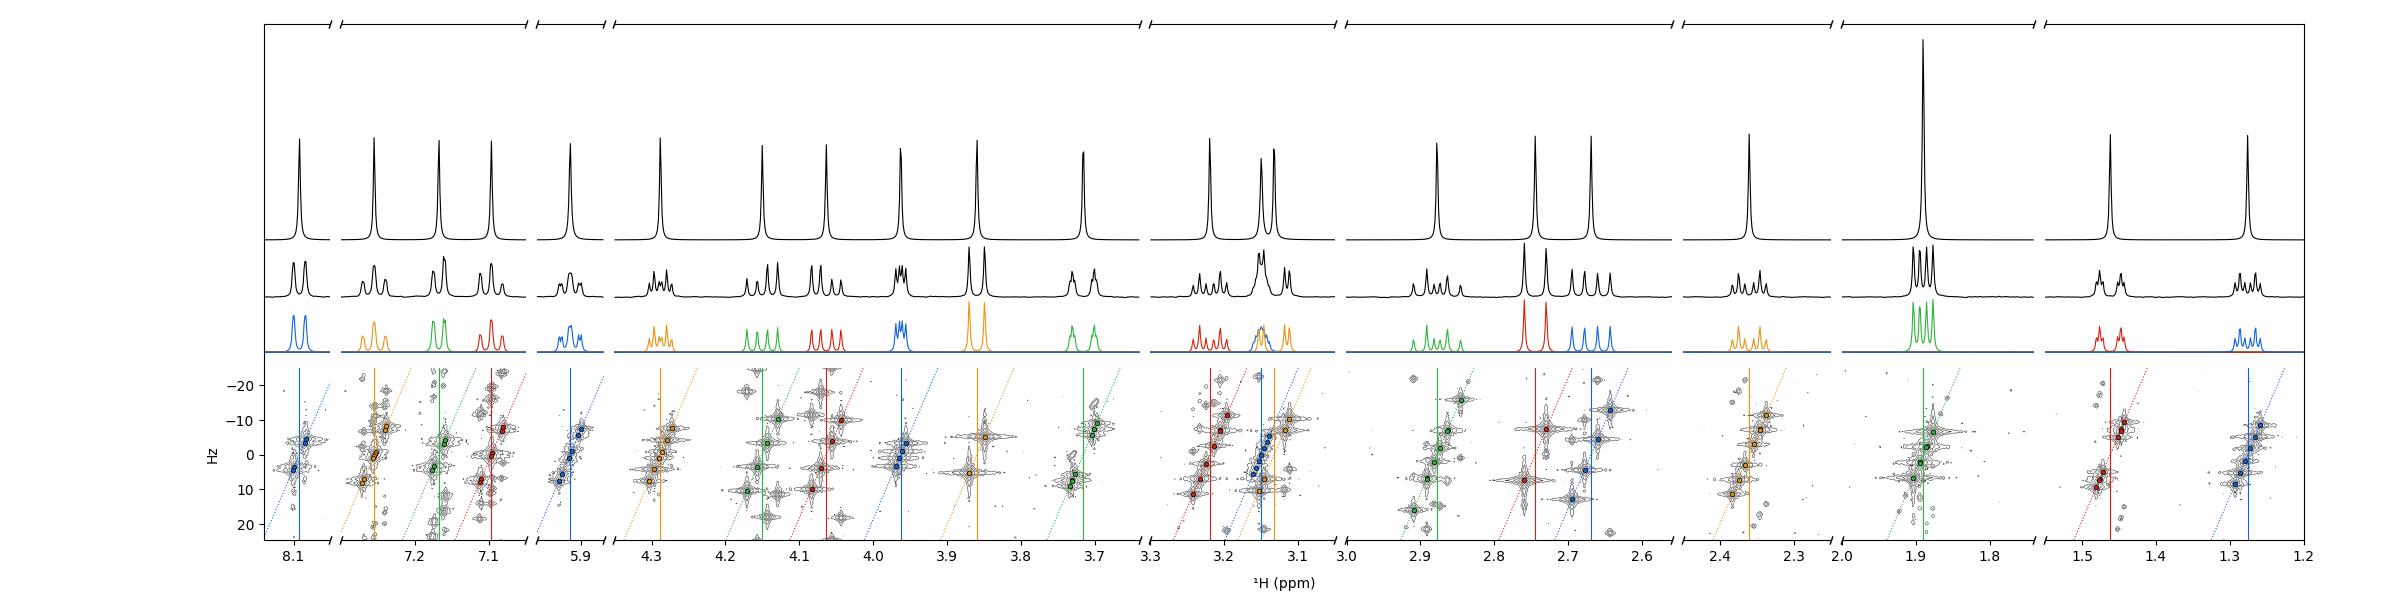

In [13]:
estimator_final_path = output_dir / "estimator_final.pkl"

if estimator_final_path.is_file():
    estimator_final = ne.Estimator2DJ.from_pickle(estimator_final_path)
else:
    estimator_final = copy.deepcopy(estimator)
    estimator_final.predict_multiplets(rm_spurious=True)
    estimator_final.to_pickle(estimator_final_path)
    
fig, _ = plot_result(estimator_final)
plt.show()

Notice how:

1. The only fit signals that have remained correspond to first-order signals in the 2DJ data.
2. Because the influence of strong coupling is neglected, the generated multiplets do not exhibit the roofing effects the the original 1D spectrum does. Most notably, see 4.2-4ppm.

## Outputting Results

The `cupid_signal()` method is used to generate a homodecoupled FID based on the estimation result.
Here, the resultant spectrum (orange) is plotted alongside the original direct dimension spectrum of the 2DJ dataset (blue).

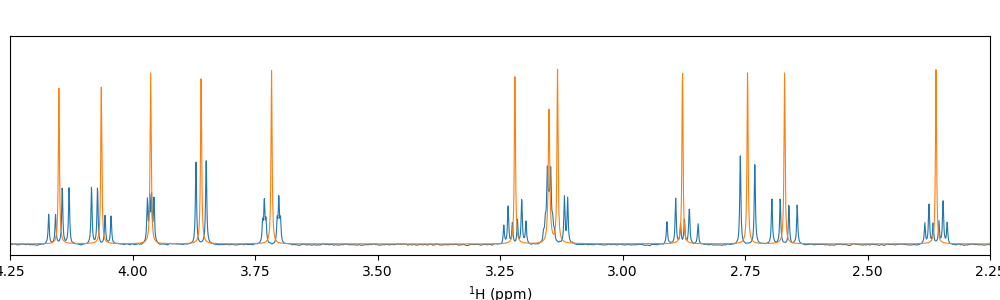

In [14]:
cupid_fid = estimator_final.cupid_signal()
fig, ax = plot_1d([direct_fid, cupid_fid])

# Zoom in on 4.25 - 2.25 ppm region
ax.set_xlim(4.25, 2.25)
old_ylim = ax.get_ylim()
new_ylim = (0.6 * old_ylim[0], 0.6 * old_ylim[1])
ax.set_ylim(new_ylim)
plt.show()

To finish, the following are written out:

1. The homodecoupled signal produced is written out to Bruker format, making it readable in TopSpin.
2. Each multiplet structure is also written to its own Bruker dataset
3. The pararmeters generated are saved to a human-readable textfile.
4. The parameters are also saved to a PDF (Requires a local LaTeX installation).

In [15]:
bruker_dir = output_dir / "bruker"
estimator_final.write_cupid_to_bruker(bruker_dir, 1, force_overwrite=True)
estimator_final.write_multiplets_to_bruker(bruker_dir, 1, force_overwrite=True)
estimator_final.write_result(output_dir / "estimation_result", force_overwrite=True)
estimator_final.write_result(output_dir / "estimation_result", fmt="pdf", force_overwrite=True)

Saved CUPID signal to output/bruker/1/
Saved multiplets to folders output/bruker/[101-121]/
Saved file output/estimation_result.txt.
Saved file output/estimation_result.tex.
Saved file output/estimation_result.pdf.
You can view and customise the corresponding TeX file at output/estimation_result.tex.
